In [1]:
from pathlib import Path
import sys

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot

%matplotlib inline

In [36]:
# List the recordings in folder
# each recording folder must be named with the first word as the label, followed by an underscore: 
# e.g. `punch_xxx` and in this folder, the csv file corresponding. 
def get_data(base_dir, files):
    # read the data
    recordings = {}

    files = Path('.').joinpath(base_dir).glob(files)

    for f in sorted(files):

        data_info = str(f).split('/')[-1].split('_')
        label = data_info[0]
        placement = data_info[-2]
        val_type  = data_info[-1].split('.')[0]

        if(val_type == 'acc' and placement == 'arm'):
            this_gesture = pd.read_csv(f, header=0, names=['Phone timestamp','sensor timestamp [ns]','X [mg]','Y [mg]','Z [mg]'], index_col=0, sep=';', parse_dates=True)
            this_gesture = this_gesture.drop('sensor timestamp [ns]',axis=1)
            this_gesture = this_gesture.rename(columns={'X [mg]': 'X_arm', 'Y [mg]': 'Y_arm', 'Z [mg]': 'Z_arm'})
            this_gesture = this_gesture.resample('100ms').mean()

            if label in recordings.keys():             # if the label already exists in the dictionary
                recordings[label].append(this_gesture) # append the new gesture to the list
            else:
                recordings[label] = [this_gesture]     # otherwise, create a list with one element

        elif(val_type == 'acc' and placement == 'feet'):

            this_gesture = pd.read_csv(f, header=0, names=['Phone timestamp','sensor timestamp [ns]','X [mg]','Y [mg]','Z [mg]'], index_col=0, sep=';', parse_dates=True)
            this_gesture = this_gesture.rename(columns={'X [mg]': 'X_feet', 'Y [mg]': 'Y_feet', 'Z [mg]': 'Z_feet'})
            this_gesture = this_gesture.drop('sensor timestamp [ns]',axis=1)
            this_gesture = this_gesture.resample('100ms').mean()

            recordings[label][-1] = recordings[label][-1].join(this_gesture, how='inner', lsuffix='left', rsuffix='right')

        elif(val_type == 'hr' and placement == 'arm'):
            
            hr = pd.read_csv(f, index_col=0, sep=';', parse_dates=True)
            hr = hr.resample('100ms').mean()
            hr = hr.fillna(method="ffill")

            recordings[label][-1] = recordings[label][-1].join(hr, how='inner', lsuffix='left', rsuffix='right')

    labels = recordings.keys()
    print(f'{len(labels)} labels found ({labels}).')

    return recordings


In [3]:
recordings = get_data('Data_old','**/*.txt')

5 labels found (dict_keys(['benchAlt', 'dead', 'ohp', 'squat', 'traction'])).


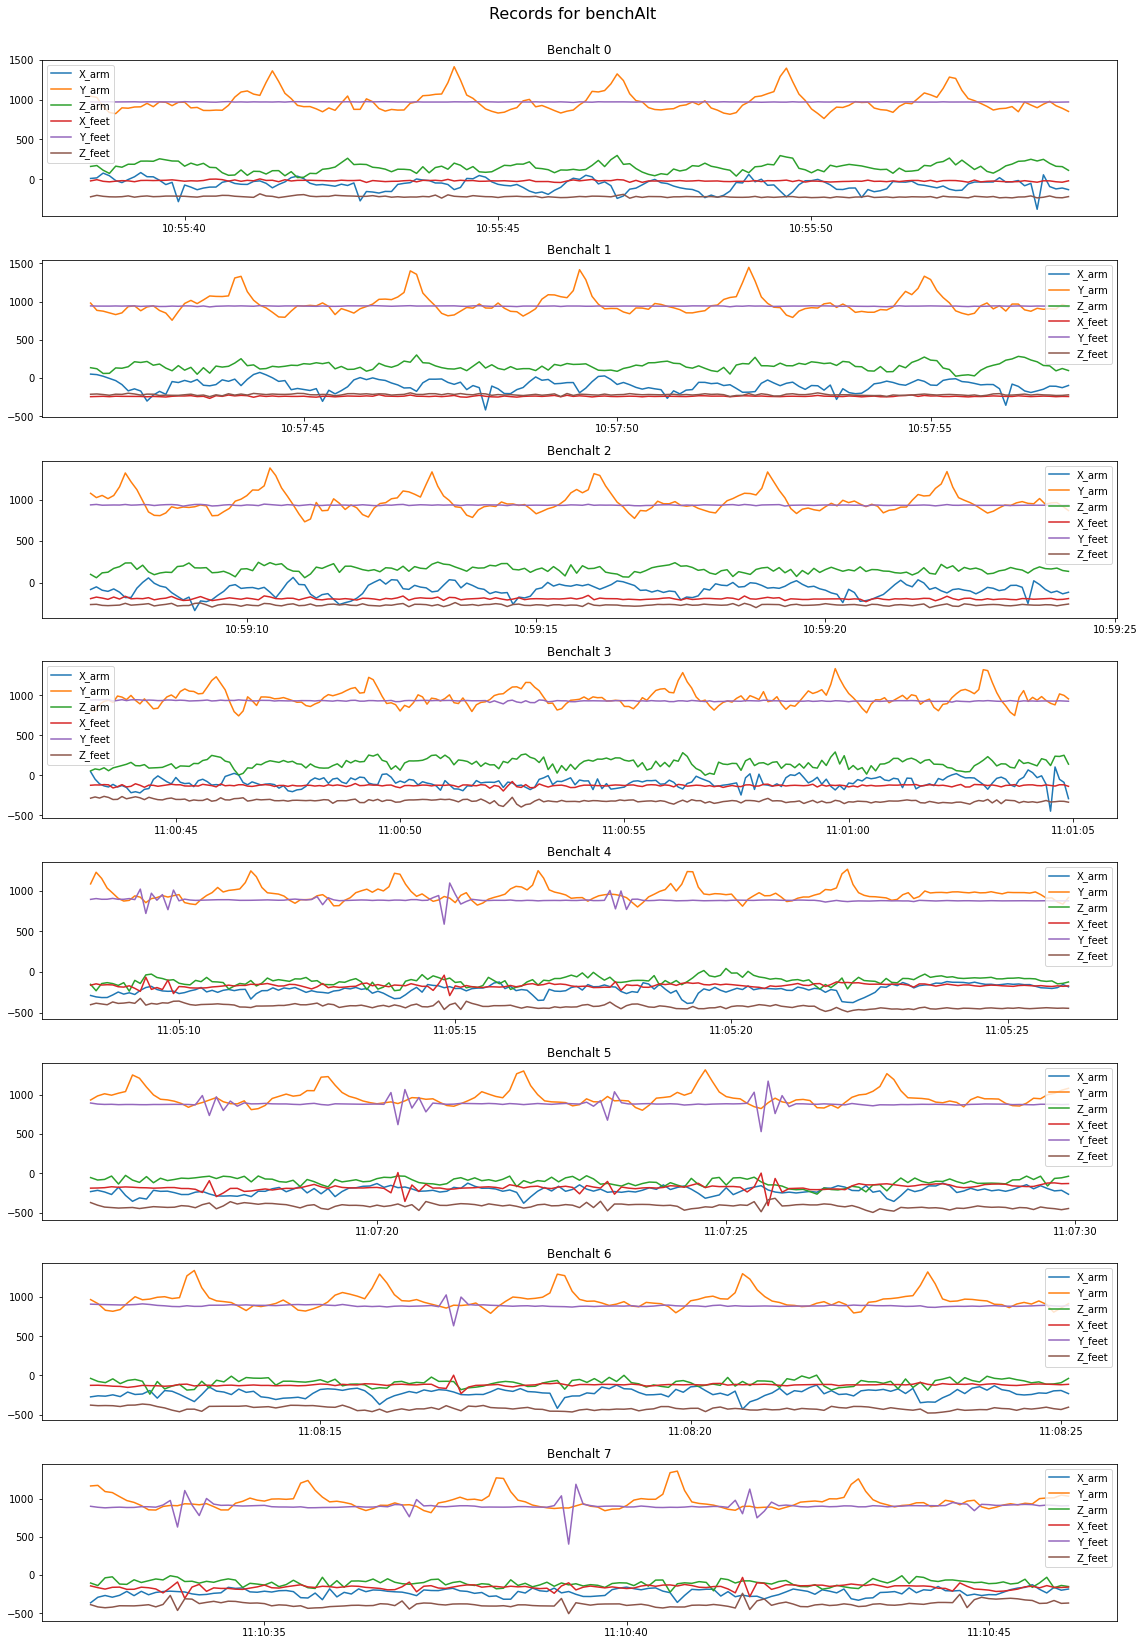

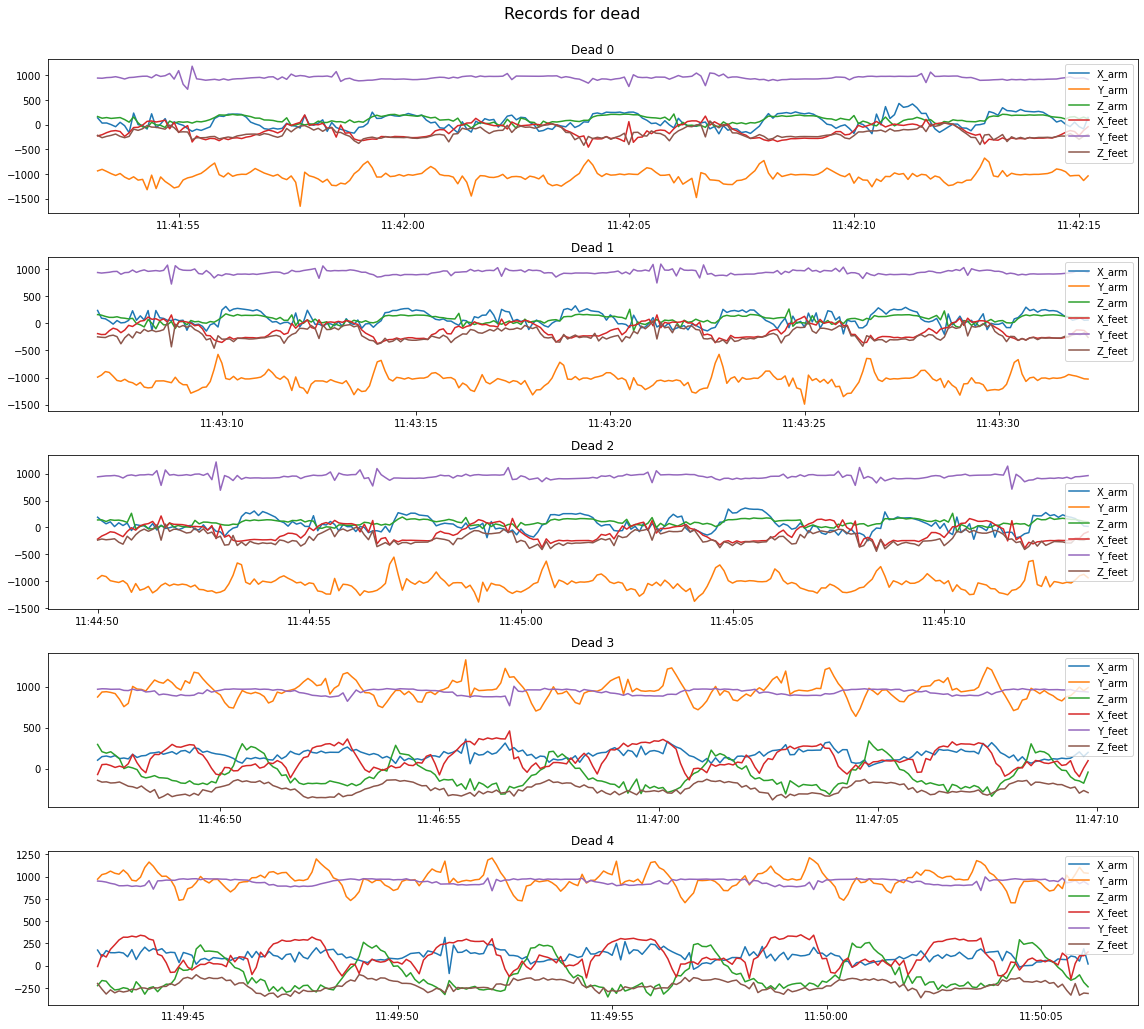

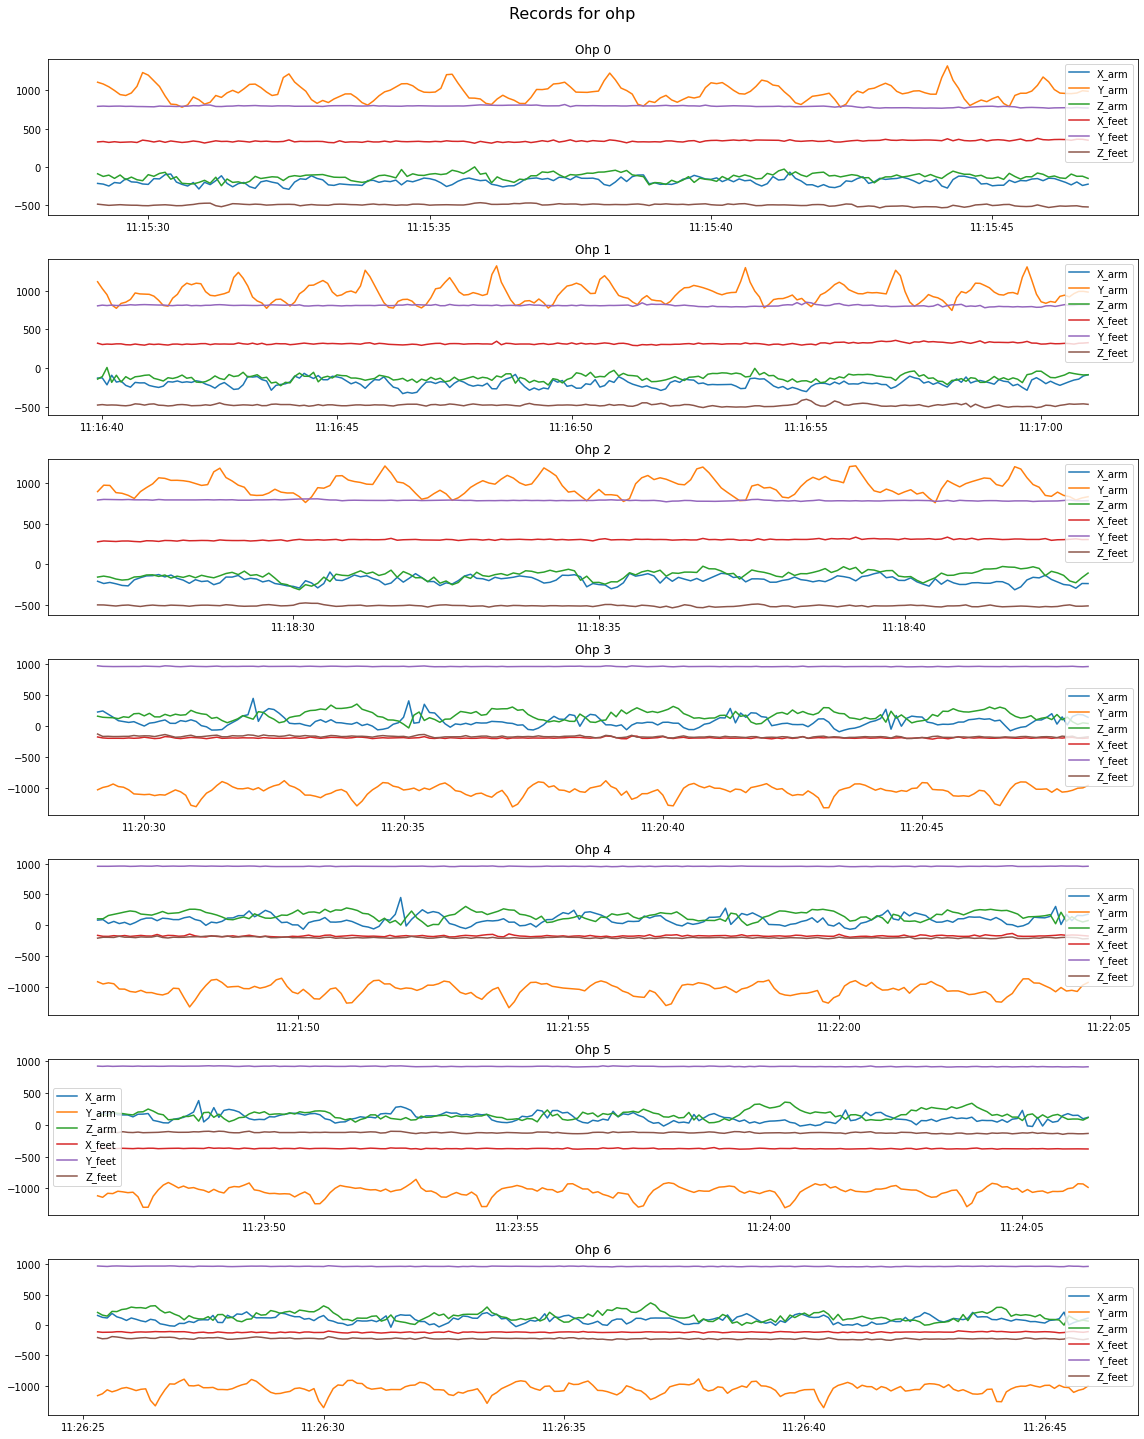

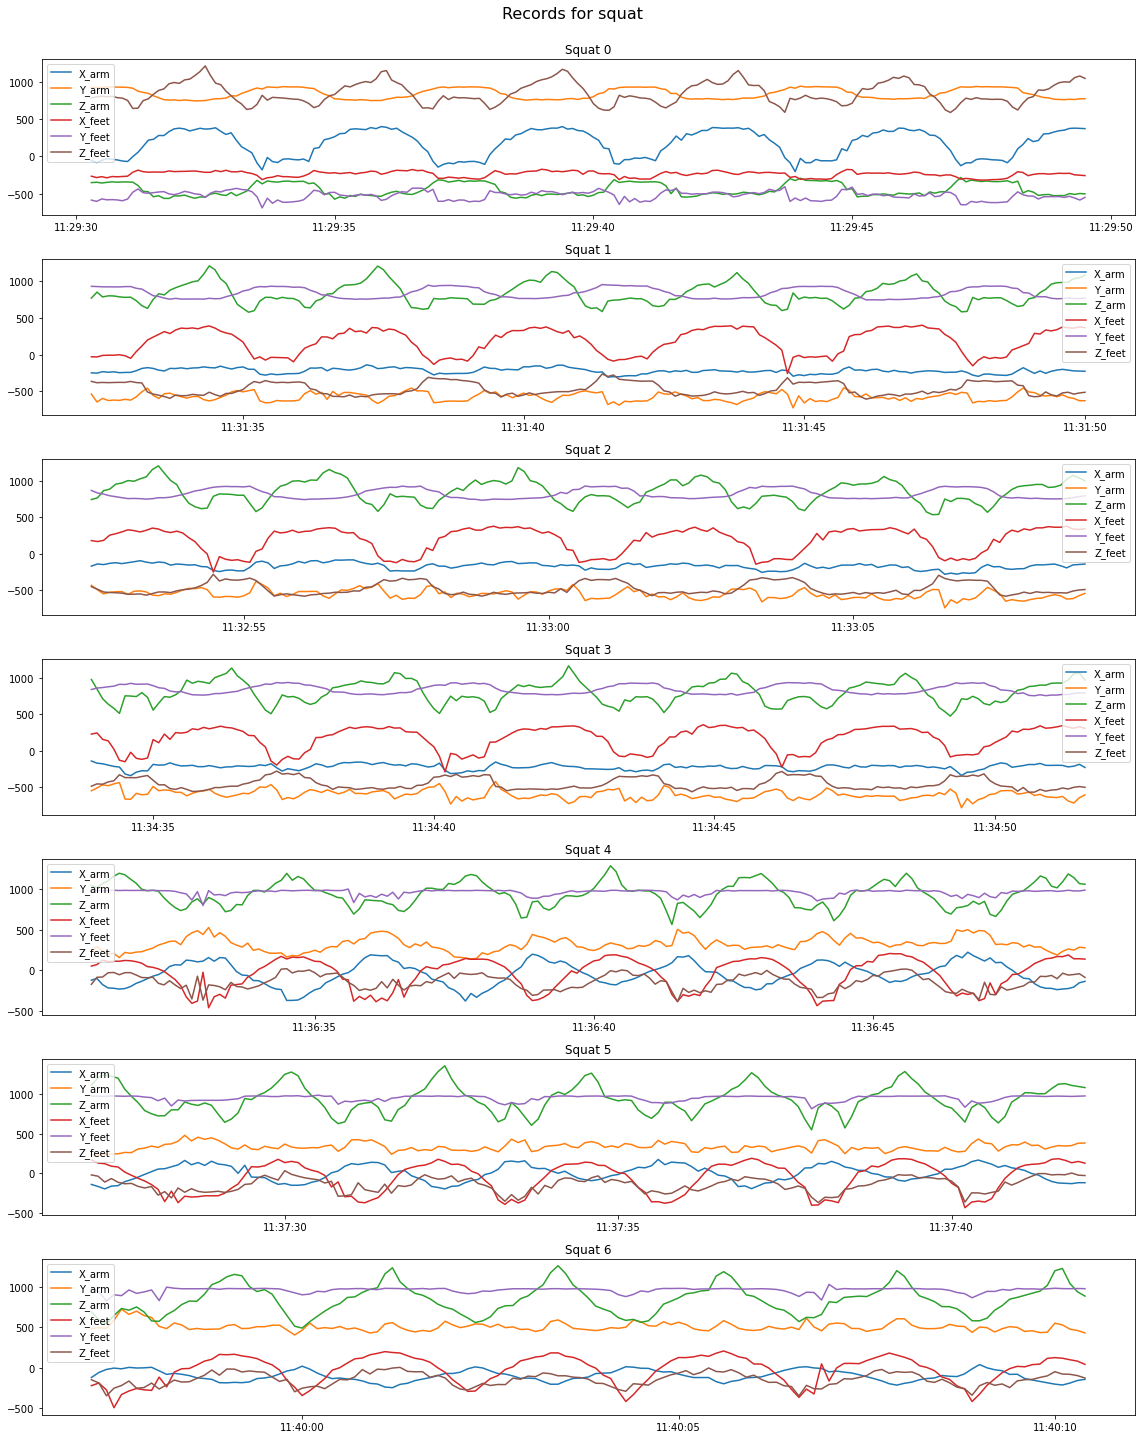

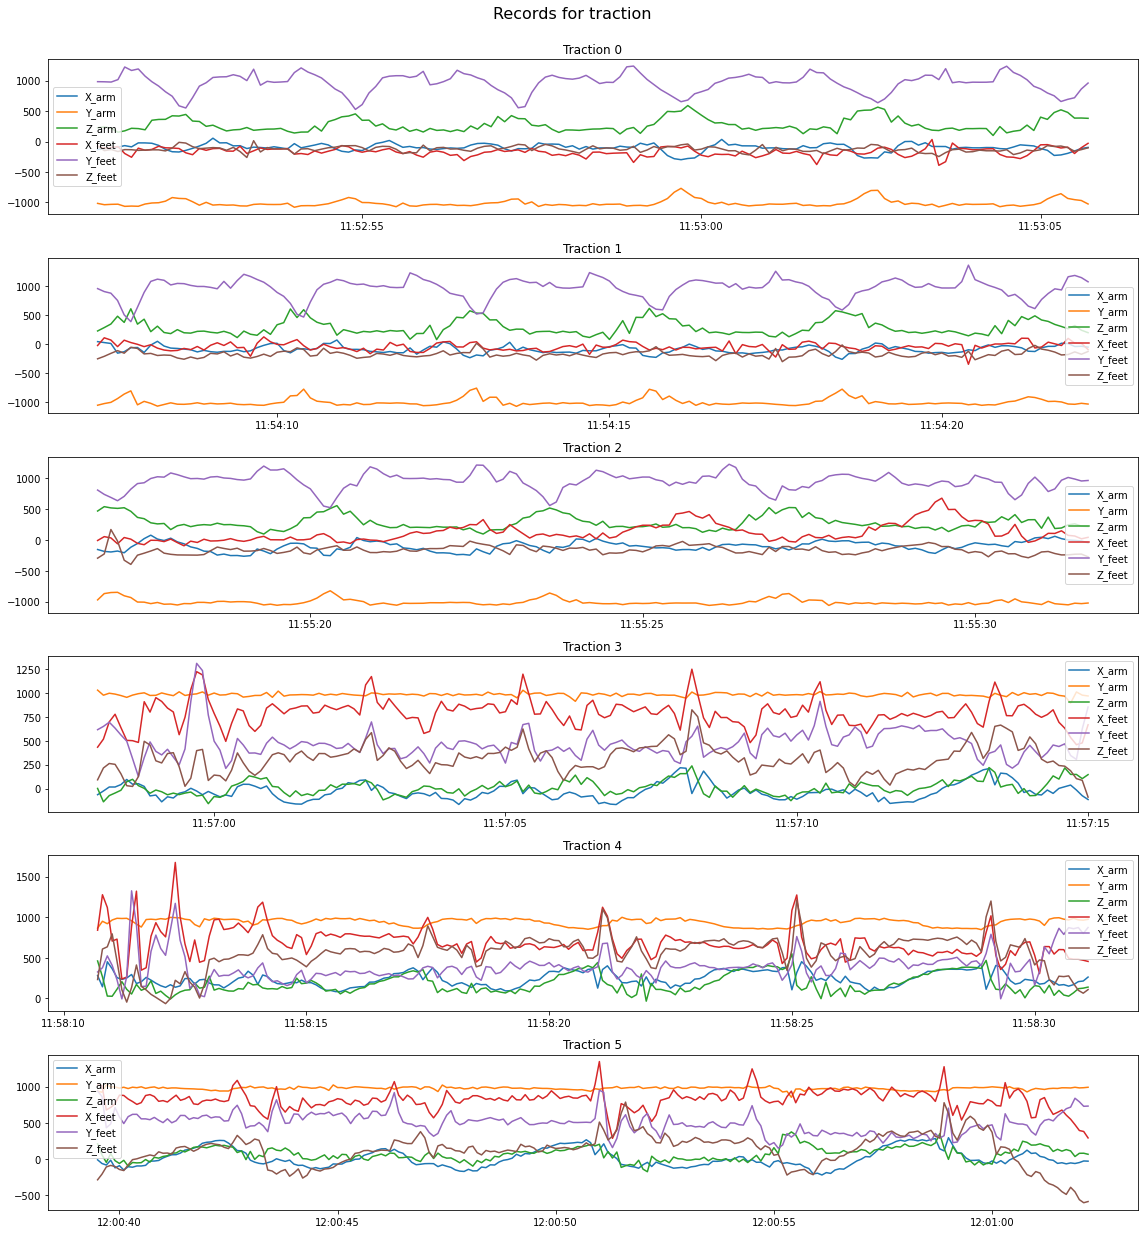

In [4]:
for label in recordings.keys():
    fig, axs = plt.subplots(len(recordings[label]), 1, figsize=(16, 3 * len(recordings[label])))
    
    for i, record in enumerate(recordings[label]):
        axs[i].plot(record[['X_arm','Y_arm','Z_arm','X_feet','Y_feet','Z_feet']])
        axs[i].set_title(f'{label.capitalize()} {i}', fontsize=12)
        axs[i].legend(['X_arm','Y_arm','Z_arm','X_feet','Y_feet','Z_feet'])
    fig.suptitle(f'Records for {label}', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [9]:
X = []
Y = []

max_nb_sample = 0
# pour chaque type de mouvement
for i, label in enumerate(recordings.keys()):
    # pour chaque enregistrement
    for record in recordings[label]:
        if max_nb_sample < record.shape[0]:
            max_nb_sample = record.shape[0]

In [10]:
X = []
Y = []

window_size = 50
padding = 5

# pour chaque type de mouvement
label_num = []
for i, label in enumerate(recordings.keys()):
    # pour chaque enregistrement
    for record in recordings[label]:
        diff = max_nb_sample - record.shape[0]
        temp = record[['X_arm','Y_arm','Z_arm','X_feet','Y_feet','Z_feet']]
        j = 0
        
        while j + window_size < temp.shape[0]:
        
            X.append(temp[j:window_size+j])
            Y.append(i)
            j += padding
        
    label_num.append(label)

In [11]:
scaler = MinMaxScaler()

X = np.array(X)
for i in range(np.array(X).shape[2]):
    X[:,:,i] = scaler.fit_transform(X[:,:,i])

In [12]:
# to onehot
print(label_num)
Y_1hot = to_categorical(Y)
print(Y_1hot)

X_train, X_test, y_train, y_test = train_test_split(X, Y_1hot, test_size=0.33, random_state=42)


['benchAlt', 'dead', 'ohp', 'squat', 'traction']
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


[0. 0. 1. 0. 0.]
(594, 50, 6)


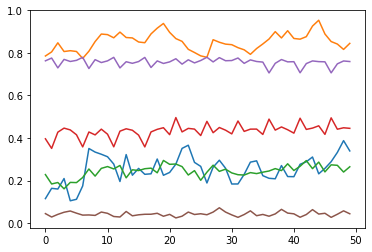

In [13]:
plt.plot(X_train[2])
print(y_train[2])
print(X_train.shape)

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.stack(X_train)
y_train = np.stack(y_train)
y_test = np.stack(y_test)
X_test = np.stack(X_test)
#n_timesteps
#n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_timesteps = window_size

verbose, epochs, batch_size = 1, 100, 10

n_features = X_train.shape[2]
n_outputs  = y_train.shape[1]

In [15]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Activation

In [16]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

Epoch 1/100
48/48 [==============================] - 1s 8ms/step - loss: 1.4457 - accuracy: 0.3874 - val_loss: 1.1508 - val_accuracy: 0.4958
Epoch 2/100
48/48 [==============================] - 0s 4ms/step - loss: 0.9752 - accuracy: 0.5453 - val_loss: 0.7439 - val_accuracy: 0.7395
Epoch 3/100
48/48 [==============================] - 0s 4ms/step - loss: 0.7162 - accuracy: 0.6589 - val_loss: 0.5744 - val_accuracy: 0.7815
Epoch 4/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5686 - accuracy: 0.7389 - val_loss: 0.4436 - val_accuracy: 0.7899
Epoch 5/100
48/48 [==============================] - 0s 4ms/step - loss: 0.4913 - accuracy: 0.7874 - val_loss: 0.3657 - val_accuracy: 0.8151
Epoch 6/100
48/48 [==============================] - 0s 4ms/step - loss: 0.4257 - accuracy: 0.8105 - val_loss: 0.3477 - val_accuracy: 0.7983
Epoch 7/100
48/48 [==============================] - 0s 4ms/step - loss: 0.3483 - accuracy: 0.8505 - val_loss: 0.3727 - val_accuracy: 0.7899
Epoch 8/100
4

Epoch 59/100
48/48 [==============================] - 0s 6ms/step - loss: 0.1218 - accuracy: 0.9389 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 60/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0888 - accuracy: 0.9621 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 61/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0799 - accuracy: 0.9537 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 62/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0997 - accuracy: 0.9347 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 63/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0923 - accuracy: 0.9579 - val_loss: 5.8731e-04 - val_accuracy: 1.0000
Epoch 64/100
48/48 [==============================] - 0s 5ms/step - loss: 0.1008 - accuracy: 0.9558 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 65/100
48/48 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9368 - val_loss: 0.0011 - val_accuracy: 1.0000
Ep

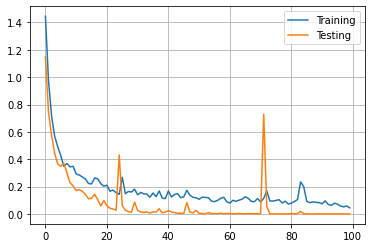

In [18]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.legend()
plt.grid()
plt.show()

In [19]:
# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print('Test loss:', accuracy[0]) 
print('Test accuracy:', accuracy[1])

Test loss: 1.6979718566290103e-05
Test accuracy: 1.0


Confusion matrix: 
[[58  0  0  0  0]
 [ 0 64  0  0  0]
 [ 0  0 71  0  0]
 [ 0  0  0 53  0]
 [ 0  0  0  0 48]]

['benchAlt', 'dead', 'ohp', 'squat', 'traction']


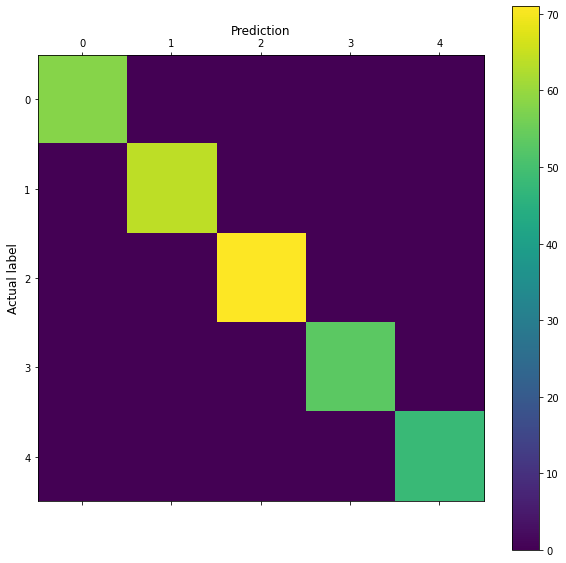

In [20]:
y_pred=model.predict(X_test)

y_pred_n = np.argmax(y_pred, axis=1)
y_test_n = np.argmax(y_test, axis=1)

# Confusion matrix
cm = metrics.confusion_matrix(y_test_n, y_pred_n)
print(f'Confusion matrix: \n{cm}\n')
print(label_num)
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
plt.matshow(cm, 0)
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Prediction', fontsize=12)
ax.xaxis.set_label_position('top')
plt.colorbar()

In [21]:
model.save('Model')

INFO:tensorflow:Assets written to: Model/assets


In [22]:
i = 0
def rolling_pred(dataset, model, padding, window):
    to_pred = []
    i = 0
    while(i+window < dataset.shape[0]):
        to_pred.append(dataset[i:i+window])
        i+=padding
    to_pred = np.stack(to_pred)
    preds = model.predict(to_pred)
    return preds

1 labels found (dict_keys(['Test'])).
(2229, 7)


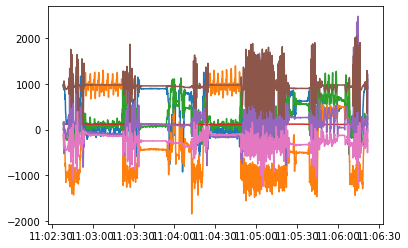

In [37]:
serie_record = get_data('Data_serie_test','**/*.txt')
serie_record = serie_record['Test'][0]
print(serie_record.shape)



plt.plot(serie_record)

In [38]:
pred = rolling_pred(serie_record[['X_arm','Y_arm','Z_arm','X_feet','Y_feet','Z_feet']], model, 1, window_size)
for pr in pred:
    print(pr)

[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0

[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0

[0.0000000e+00 2.8061596e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 

(2229,)


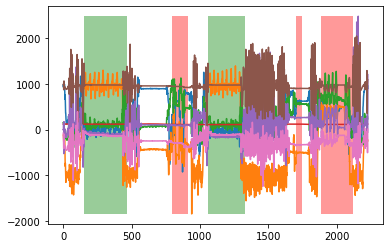

In [39]:

pred_int = np.argmax(pred,axis=1)
pred_int = np.pad(pred_int, (50,0), 'edge')
print(pred_int.shape)

min_val = np.min(np.array(serie_record).flatten())
max_val = np.max(np.array(serie_record).flatten())

index = np.arange(0,serie_record.shape[0])
plt.fill_between(index, min_val, max_val, where=pred_int==0, facecolor='green', alpha=0.4, label='upstairs')
plt.fill_between(index, min_val, max_val, where=pred_int==3, facecolor='red', alpha=0.4, label='upstairs')
plt.plot(index,serie_record)

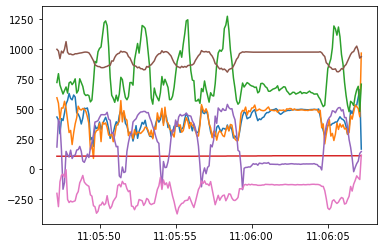

In [41]:

splits_sqt = []
for x in np.split(serie_record, np.where(pred_int!=3)[0]):
    if x.shape[0] > 10:
        splits_sqt.append(x)
plt.plot(splits_sqt[2][:-35])


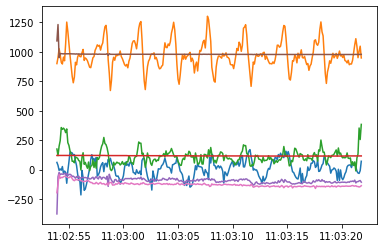

In [42]:
splits_bnch = []
for x in np.split(serie_record, np.where(pred_int!=0)[0]):
    if x.shape[0] > 10:
        splits_bnch.append(x)
plt.plot(splits_bnch[0][:-35])
